In [1]:
import numpy as np
import pandas as pd

In [6]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [2]:
df = pd.read_pickle('/Users/linggeli/chemistry/images.pkl')

In [3]:
df.head()

,empty,v0,alpha,defocus,astig_mag,astig_angle,Cs,C5,HAADF,BF
0,[0],200.0,25.0,0.0,3.0,218.0,0.0,0.0,"[[6077.966383437542, 5873.16598480453, 5286.27...","[[38935261.03899363, 38935916.2752696, 3893782..."
1,[0],200.0,25.0,0.0,-32.0,7.0,0.0,0.0,"[[2030.4218178851645, 2007.284605339987, 1914....","[[38949127.667159565, 38949200.809813626, 3894..."
2,[0],200.0,25.0,0.0,-14.0,236.0,0.0,0.0,"[[4974.975770298894, 4816.746670931963, 4364.0...","[[38939046.17134134, 38939542.93186685, 389410..."
3,[0],200.0,25.0,0.0,25.0,19.0,0.0,0.0,"[[3108.4082221742615, 3015.2100062369936, 2774...","[[38945446.15357177, 38945744.81940919, 389465..."
4,[0],200.0,25.0,0.0,-48.0,105.0,0.0,0.0,"[[598.4442089536583, 600.7411240792431, 621.22...","[[38953970.32038059, 38953948.98710649, 389538..."


In [4]:
X_images = np.zeros((300, 128, 128))

In [5]:
for i in range(300):
    X_images[i, :, :] = df['HAADF'][i]

In [8]:
X_images_scaled = (X_images - np.mean(X_images)) / np.std(X_images)

(128, 128)


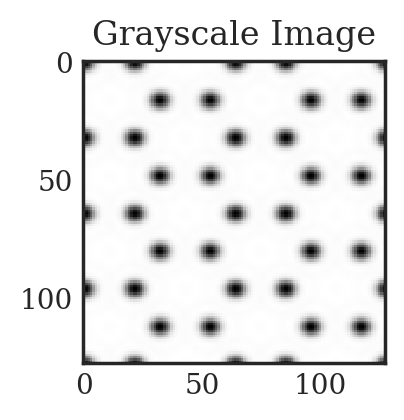

In [159]:
fig = plt.figure(figsize=(2, 2), dpi=200)
img = X_images_scaled[0, :, :]
print(img.shape)
plt.imshow(img)
plt.title('Grayscale Image')
plt.show()

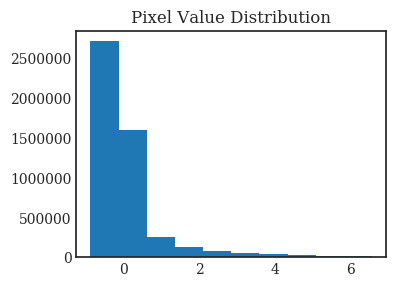

In [164]:
fig = plt.figure(figsize=(4, 3), dpi=100)
plt.hist(X_images_scaled.flatten())
plt.title('Pixel Value Distribution')
plt.show()

In [155]:
def sample_patch(img):
    """
    Randomly sample a 56 x 56 patch of the image and reduce it to size 28 x 28. 
    """
    x_start = np.random.randint(0, 128 - 56, 1)[0]
    y_start = np.random.randint(0, 128 - 56, 1)[0]
    patch = img[x_start:(x_start + 56):2, y_start:(y_start + 56):2]
    return patch

(28, 28)


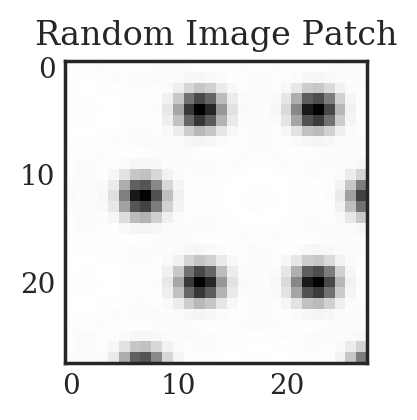

In [165]:
fig = plt.figure(figsize=(2, 2), dpi=200)
patch = sample_patch(X_images_scaled[0, :, :])
print(patch.shape)
plt.imshow(patch)
plt.title('Random Image Patch')
plt.show()

In [126]:
X_patches = np.zeros((3000, 28, 28))
X_patches_vec = np.zeros((3000, 28 * 28))
y_patches = np.zeros(3000)
for i in range(3000):
    img_index = i / 10
    img = X_images_scaled[img_index, :, :]
    patch = sample_patch(img)
    X_patches[i, :, :] = patch
    X_patches_vec[i, :] = patch.flatten()
    y_patches[i] = df['astig_mag'][img_index]

In [120]:
from sklearn.decomposition import PCA

In [127]:
pca = PCA(n_components=10)
pca.fit(X_patches_vec)
print(pca.explained_variance_ratio_)  

[0.08914844 0.08617748 0.0807745  0.07883187 0.0742125  0.07077665
 0.06870952 0.06333618 0.05958354 0.05182861]


## Train a simple MNIST model

In [12]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [13]:
import keras.datasets.mnist as mnist

In [14]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape[0], 'Number of train samples')
print(x_test.shape[0], 'Number of test samples')
print('x_train shape:', x_train.shape)

(60000, 'Number of train samples')
(10000, 'Number of test samples')
('x_train shape:', (60000, 28, 28))


In [15]:
# This makes sure the image has the correct order in the axis for Tensorflow, it would be different for Theano backend
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Convert values to floats, originally they are integers
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Scale the inputs
x_train /= 255.0  # The image is in grayscale and has values between 0 and 255
x_test /= 255.0

# Convert values of labels from 0 to 9 to categorical (one_hot encoding)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [16]:
print(x_train.shape, y_train.shape)

((60000, 28, 28, 1), (60000, 10))


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

In [36]:
model = Sequential()
model.add(Conv2D(10, (3, 3), padding='same', input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(10, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 10)        910       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 10)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 490)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                31424     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
__________

In [39]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 24s 397us/step - loss: 0.5355 - acc: 0.8306 - val_loss: 0.1221 - val_acc: 0.9628
Epoch 2/10
60000/60000 [==============================] - 26s 431us/step - loss: 0.2003 - acc: 0.9393 - val_loss: 0.0773 - val_acc: 0.9743
Epoch 3/10
60000/60000 [==============================] - 24s 395us/step - loss: 0.1596 - acc: 0.9523 - val_loss: 0.0593 - val_acc: 0.9792
Epoch 4/10
60000/60000 [==============================] - 24s 394us/step - loss: 0.1323 - acc: 0.9612 - val_loss: 0.0552 - val_acc: 0.9816
Epoch 5/10
60000/60000 [==============================] - 24s 392us/step - loss: 0.1186 - acc: 0.9645 - val_loss: 0.0506 - val_acc: 0.9825
Epoch 6/10
60000/60000 [==============================] - 24s 404us/step - loss: 0.1071 - acc: 0.9677 - val_loss: 0.0502 - val_acc: 0.9836
Epoch 7/10
60000/60000 [==============================] - 19s 325us/

In [82]:
from keras.models import Model

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('dense_11').output)

In [128]:
x_new = X_patches.reshape(X_patches.shape[0], 28, 28, 1)
x_new = x_new.astype('float32')

In [129]:
mnist_output = intermediate_layer_model.predict(x_new)

In [130]:
print(mnist_output.shape)

(3000, 64)


In [169]:
y_label = np.ceil(np.absolute(y_patches) / 10)
y_label[y_label == 0] = 1

1.0
5.0


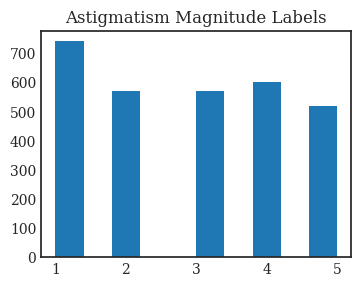

In [170]:
print(np.min(y_label))
print(np.max(y_label))
fig = plt.figure(figsize=(4, 3), dpi=100)
plt.hist(y_label.flatten())
plt.title('Astigmatism Magnitude Labels')
plt.show()

In [137]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [171]:
clf = LogisticRegressionCV(cv=10, solver='lbfgs', multi_class='multinomial').fit(mnist_output, y_label)

In [172]:
y_hat = clf.predict(mnist_output)
print(np.mean(y_hat == y_label))

0.8823333333333333


In [173]:
from sklearn.metrics import confusion_matrix

In [174]:
matrix = confusion_matrix(y_label, y_hat)
print(matrix)

[[661  79   0   0   0]
 [108 441  21   0   0]
 [  0  49 503  18   0]
 [  0   0  19 543  38]
 [  0   0   0  21 499]]


Normalized confusion matrix


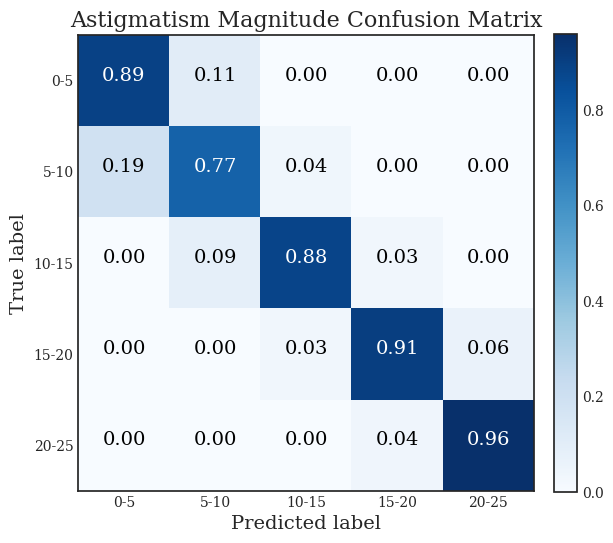

In [176]:
fig = plt.figure(figsize=(6, 6), dpi=100)
plot_confusion_matrix(matrix, 
                      classes=['0-5', '5-10', '10-15', '15-20', '20-25'],#, '25-30', '30-35', '35-40', '40-45', '45-50'], 
                      normalize=True,
                      title='Astigmatism Magnitude Confusion Matrix')
plt.show()

In [142]:
import itertools

In [145]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)